# Dog Breed Classifier using Transfer Learning

In [1]:
import numpy as np
from glob import glob
          
# load filenames for dog images
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))


There are 8351 total dog images.


In [2]:
import torch
import torchvision.models as models

import os
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.utils.data as data
import torch.nn as nn

torch.manual_seed(12345)

print(torch.__version__)

1.4.0


In [3]:
# use pretrained resnet152 model
resnet152 = models.resnet152(pretrained=True, progress=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    resnet152 = resnet152.cuda()
    print('Model transferred to CUDA!')

Model transferred to CUDA!


In [4]:
import pickle
file = open('imagenet1000_clsid_to_human_unix.pkl', 'rb')        
ImageNetClasses = pickle.load( file )     

In [5]:
from PIL import Image
import torchvision.transforms as transforms


# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def cnn_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    #taken from https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
    
    #Load
    image = Image.open(img_path)
    #image.show()  #Check
    
    #pre-process
    #define transformer
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    #create transformed image
    image_t = transform(image).cuda()
    #create batch of images
    batch_t = torch.unsqueeze(image_t, 0).cuda()
    
    resnet152.eval()
    out = resnet152(batch_t)
    
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    #get the index of the best prediction
    pred_value_t, pred_index_t = torch.topk(percentage, 1)
    
    #pred_index_t is a tensor, we need the value (that is the index!)
    pred_index=pred_index_t.item()
    
    return pred_index # predicted class index

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline    
import random 

In [7]:
def LoadImageResized(filename,resize=True, dim=(224,224)):
    img = cv2.imread(filename)
    if resize:
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(cv_rgb)

In [8]:
def ShowImage(filename, resize=True):
    plt.imshow(LoadImageResized(filename,resize))
    plt.show()

In [9]:
### GENERATE RANDOM IMAGE-FILES-LIST FOR PLOT ###
randomfiles = []
classnames = []
for i in range(4):
    randomfile = random.choice(dog_files) 
    ClassName = ImageNetClasses.get(cnn_predict(randomfile))
    randomfiles.append(randomfile)
    classnames.append(ClassName)

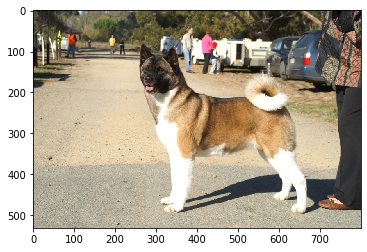

In [10]:
ShowImage(randomfile,resize=False)

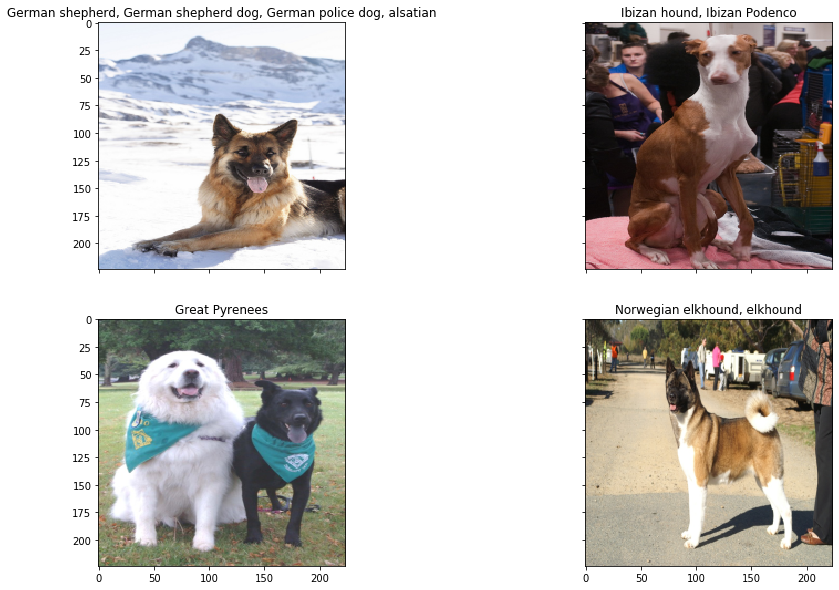

In [11]:
f, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (16,10))

dim = (224,224)
#for ax, img, title in zip(axes.ravel(), images[random_id], df['label'][random_id]):
for ax, fname, title in zip(axes.ravel(), randomfiles, classnames):
    ax.imshow(LoadImageResized(fname))
    ax.set_title(title)

In [12]:
## TODO: Specify data loaders


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# define train, valid and test data directories
dog_dir = 'dogImages'
train_dir = os.path.join(dog_dir, 'train/')
valid_dir = os.path.join(dog_dir, 'valid/')
test_dir = os.path.join(dog_dir, 'test/')
# load and transform data
RESIZE = 256
FSIZE = 224
# perform data transform WITH DATA AUGMENTATION for training data
train_data_transform = transforms.Compose([transforms.RandomResizedCrop(FSIZE),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# perform data transform for valid/test data (NO DATA AUGMENTATION)
# we only resize, crop and normalize the valid/test dataset
valid_test_data_transform = transforms.Compose([transforms.Resize(RESIZE),
                                                transforms.CenterCrop(FSIZE),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_data_transform)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_data_transform)
# print out some data stats
print('Total num of breeds: ', len(train_data.classes))
#N_CLASSES defines the number of outputs of the fully-connected neural network
N_CLASSES = len(train_data.classes)

print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))


batch_size = 16
num_workers = 0


train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers,
                                          shuffle=True)
# store all 3 above loaders into a dictionary
loaders_transfer = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

Total num of breeds:  133
Num training images:  6680
Num validation images:  835
Num test images:  836


In [13]:
## TODO: Specify model architecture 

model_transfer = models.densenet161(pretrained=True)
#model_transfer=resnet152
if use_cuda:
    model_transfer = model_transfer.cuda()


In [14]:
model_transfer

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
# Freeze model weights
for param in model_transfer.parameters():
    param.requires_grad = False

In [16]:
features = model_transfer._modules['features']
features

Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(144, 192, 

In [17]:
CNN_output = features._modules['norm5']
CNN_output

BatchNorm2d(2208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [18]:
num_ftrs = model_transfer.classifier.in_features
num_ftrs

2208

In [19]:
#Adding custom classifier
#How to add , see my comment in
#https://discuss.pytorch.org/t/pytorch-transfer-learning-with-densenet/15579/8

import torch.nn as nn
# Add on classifier
n_inputs = num_ftrs  #number inputs given by Densenet-161 Architecture
n_classes = 133

model_transfer.classifier = nn.Linear(n_inputs, n_classes)        


In [20]:
model_transfer

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [21]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()
    print("Model transferred to CUDA!")


Model transferred to CUDA!


In [22]:
import torch.optim as optim

#Try with learning rates {0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001}
LEARNING_RATE = 0.01
MOMENTUM = 0.5
NESTEROV = True

criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=NESTEROV)

In [23]:
import pickle

def loadvalidlossmin(fname):
    return pickle.load(open(fname, "rb"))

def savevalidlossmin(fname, lossval):
    pickle.dump(lossval, open(fname, "wb"))
    

In [24]:
RESTART = True
if RESTART == True:
    print('Initializing training!')
    #Arrays for plotting training performance
    #Avoid re-initialization if training is resumed with again N_EPOCHS!
    train_loss_history = []
    valid_loss_history = []
    valid_loss_min = np.Inf 
else:
    print('Resuming training!')
    model_transfer.load_state_dict(torch.load('model_transfer2.pt'))
    valid_loss_min = loadvalidlossmin('transfer_lossmin.p')

Initializing training!


In [25]:
valid_loss_min

inf

In [26]:
#https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
# Find total parameters and trainable parameters
# With this verify that the Convolutional Network is not going to be retrained!
total_params = sum(p.numel() for p in model_transfer.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_transfer.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

26,765,797 total parameters.
293,797 training parameters.


In [27]:
# train the model
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    global valid_loss_min
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
 
            #Reset gradients to zero in order not to accumulate throughout the batches.
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            #calculate the train_loss_history (not cummulated)
            train_loss_history.append(loss.item())
            #calculate the train_loss (cummulated)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            #Set modulus size to smaller than 300 if you want see some progress in between
            #if batch_idx % 20000 == 0:
            #    print('Epoch %d, Batch %d training loss: %.6f' %
            #      (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            
            valid_loss_history.append(loss.item())
            
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss        
            savevalidlossmin('transfer_lossmin.p',valid_loss_min)
    # return trained model
    return model




In [28]:

# train the model
N_EPOCHS = 20


model_transfer = train(N_EPOCHS, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')


#Results after 20 Epochs, converging extremely fast!
#Question: Why is the validation loss around 40-60% lower than the training loss? 
#Underfitting – Validation and training error high
#Overfitting – Validation error is high, training error low
#Good fit – Validation error low, slightly higher than the training error
#Unknown fit - Validation error low, training error 'high'
#Source: https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

Epoch: 1 	Training Loss: 3.101951 	Validation Loss: 1.378057
Validation loss decreased (inf --> 1.378057).  Saving model ...
Epoch: 2 	Training Loss: 1.505997 	Validation Loss: 0.732091
Validation loss decreased (1.378057 --> 0.732091).  Saving model ...
Epoch: 3 	Training Loss: 1.141793 	Validation Loss: 0.586974
Validation loss decreased (0.732091 --> 0.586974).  Saving model ...
Epoch: 4 	Training Loss: 0.974700 	Validation Loss: 0.475464
Validation loss decreased (0.586974 --> 0.475464).  Saving model ...
Epoch: 5 	Training Loss: 0.870006 	Validation Loss: 0.426450
Validation loss decreased (0.475464 --> 0.426450).  Saving model ...
Epoch: 6 	Training Loss: 0.800158 	Validation Loss: 0.395683
Validation loss decreased (0.426450 --> 0.395683).  Saving model ...
Epoch: 7 	Training Loss: 0.768857 	Validation Loss: 0.385083
Validation loss decreased (0.395683 --> 0.385083).  Saving model ...
Epoch: 8 	Training Loss: 0.736839 	Validation Loss: 0.357632
Validation loss decreased (0.38508

In [29]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

<All keys matched successfully>

In [30]:
# Copy paste from model_scratch
test_loss_history = []

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        
        test_loss_history.append(loss.item())
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.324235


Test Accuracy: 89% (751/836)


VGG16 after 20 EPOCHS

- Test Loss: 0.319871
- Test Accuracy: 89% (745/836)

Resnet152 after 20 EPOCHS

- Test Loss: 0.324935
- Test Accuracy: 88% (739/836)

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]


from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def predict_breed_transfer(img_path):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to model_transfer model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    #Load
    image = Image.open(img_path)
    
    #pre-process
    #define transformer
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    #create transformed image
    image_t = transform(image).cuda()
    #create batch of images
    batch_t = torch.unsqueeze(image_t, 0).cuda()
    
    model_transfer.eval()
    out = model_transfer(batch_t)
    
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    #get the index of the best prediction
    pred_value_t, pred_index_t = torch.topk(percentage, 1)
    
    #pred_index_t is a tensor, we need the value (that is the index!)
    pred_index=pred_index_t.item()
    
    pred_value_t, pred_index_t = torch.topk(percentage, 5)
    
    return pred_index, pred_value_t, pred_index_t  # predicted class index plus topk-5



In [32]:
#https://github.com/elenab/project-dog-breed-classifier/blob/master/dog_app.ipynb
def image_to_tensor(img_path):
    '''
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [33]:
#I cannot use this one:
#class_names = [item[4:].replace("_", " ") for item in  image_datasets['train'].classes]

class_names = [item[4:].replace("_", " ") for item in  test_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    return class_names[pred]

In [34]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

Groundtruth: dogImages\test\006.American_eskimo_dog\American_eskimo_dog_00406.jpg


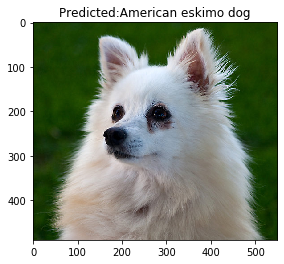

Groundtruth: dogImages\test\007.American_foxhound\American_foxhound_00512.jpg


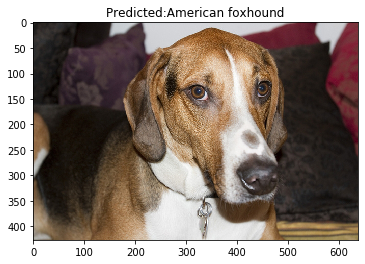

Groundtruth: dogImages\test\008.American_staffordshire_terrier\American_staffordshire_terrier_00607.jpg


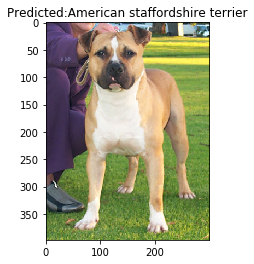

Groundtruth: dogImages\test\001.Affenpinscher\Affenpinscher_00058.jpg


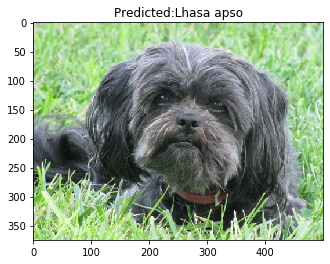

Groundtruth: dogImages\test\007.American_foxhound\American_foxhound_00484.jpg


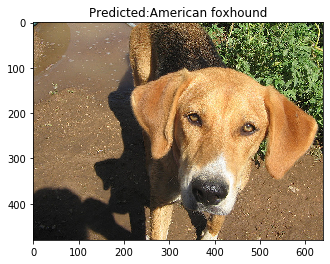

Groundtruth: dogImages\test\011.Australian_cattle_dog\Australian_cattle_dog_00730.jpg


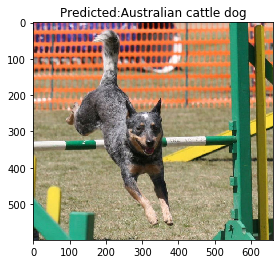

Groundtruth: dogImages\test\003.Airedale_terrier\Airedale_terrier_00175.jpg


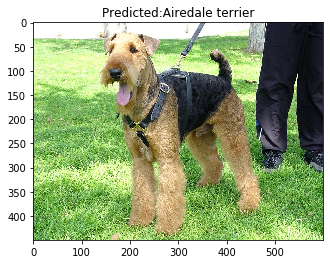

Groundtruth: dogImages\test\005.Alaskan_malamute\Alaskan_malamute_00346.jpg


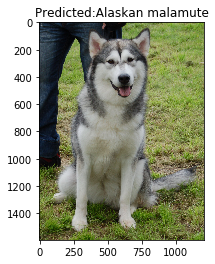

Groundtruth: dogImages\test\006.American_eskimo_dog\American_eskimo_dog_00452.jpg


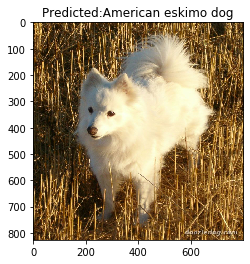

Groundtruth: dogImages\test\001.Affenpinscher\Affenpinscher_00023.jpg


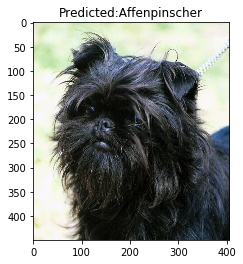

In [35]:
import random
dog_files_short = dog_files[:100]
# Try out the function
for image in random.sample(list(dog_files_short), 10): 
    predicted_breed = predict_breed_transfer(image)

    print('Groundtruth: '+str(image))
    display_image(image, title=f"Predicted:{predicted_breed}")
    

In [36]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if predict_breed_transfer(img_path):
        print('Hey puppy!')
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")        
    else:
        print('I have no clue what you are!')
        display_image(img_path, title="what are you?")


Hey puppy!


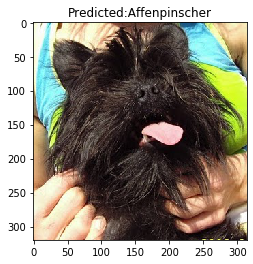

Hey puppy!


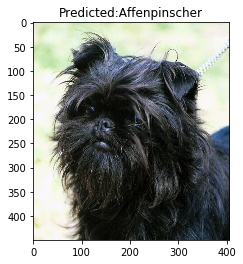

Hey puppy!


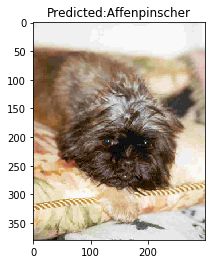

Hey puppy!


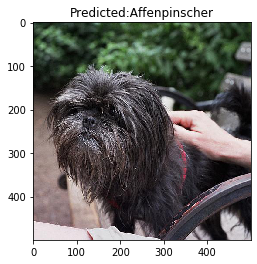

Hey puppy!


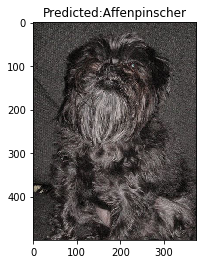

Hey puppy!


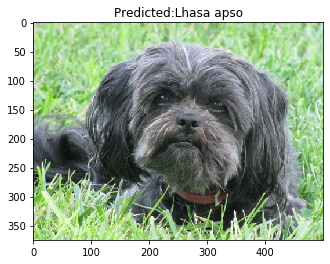

In [37]:
for file in np.hstack((dog_files[:6])):
    run_app(file)